In [0]:
#%run ./init

INFO: Image loaded successfully.
INFO:MudSectionExtractor:Image loaded successfully.


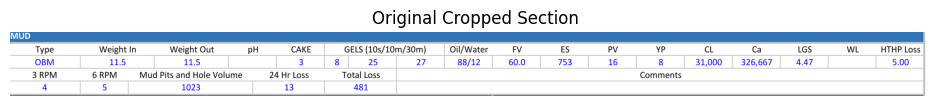

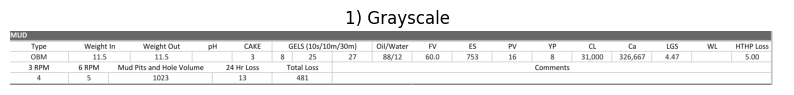

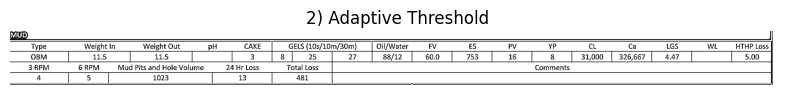

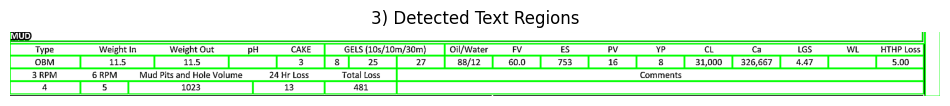

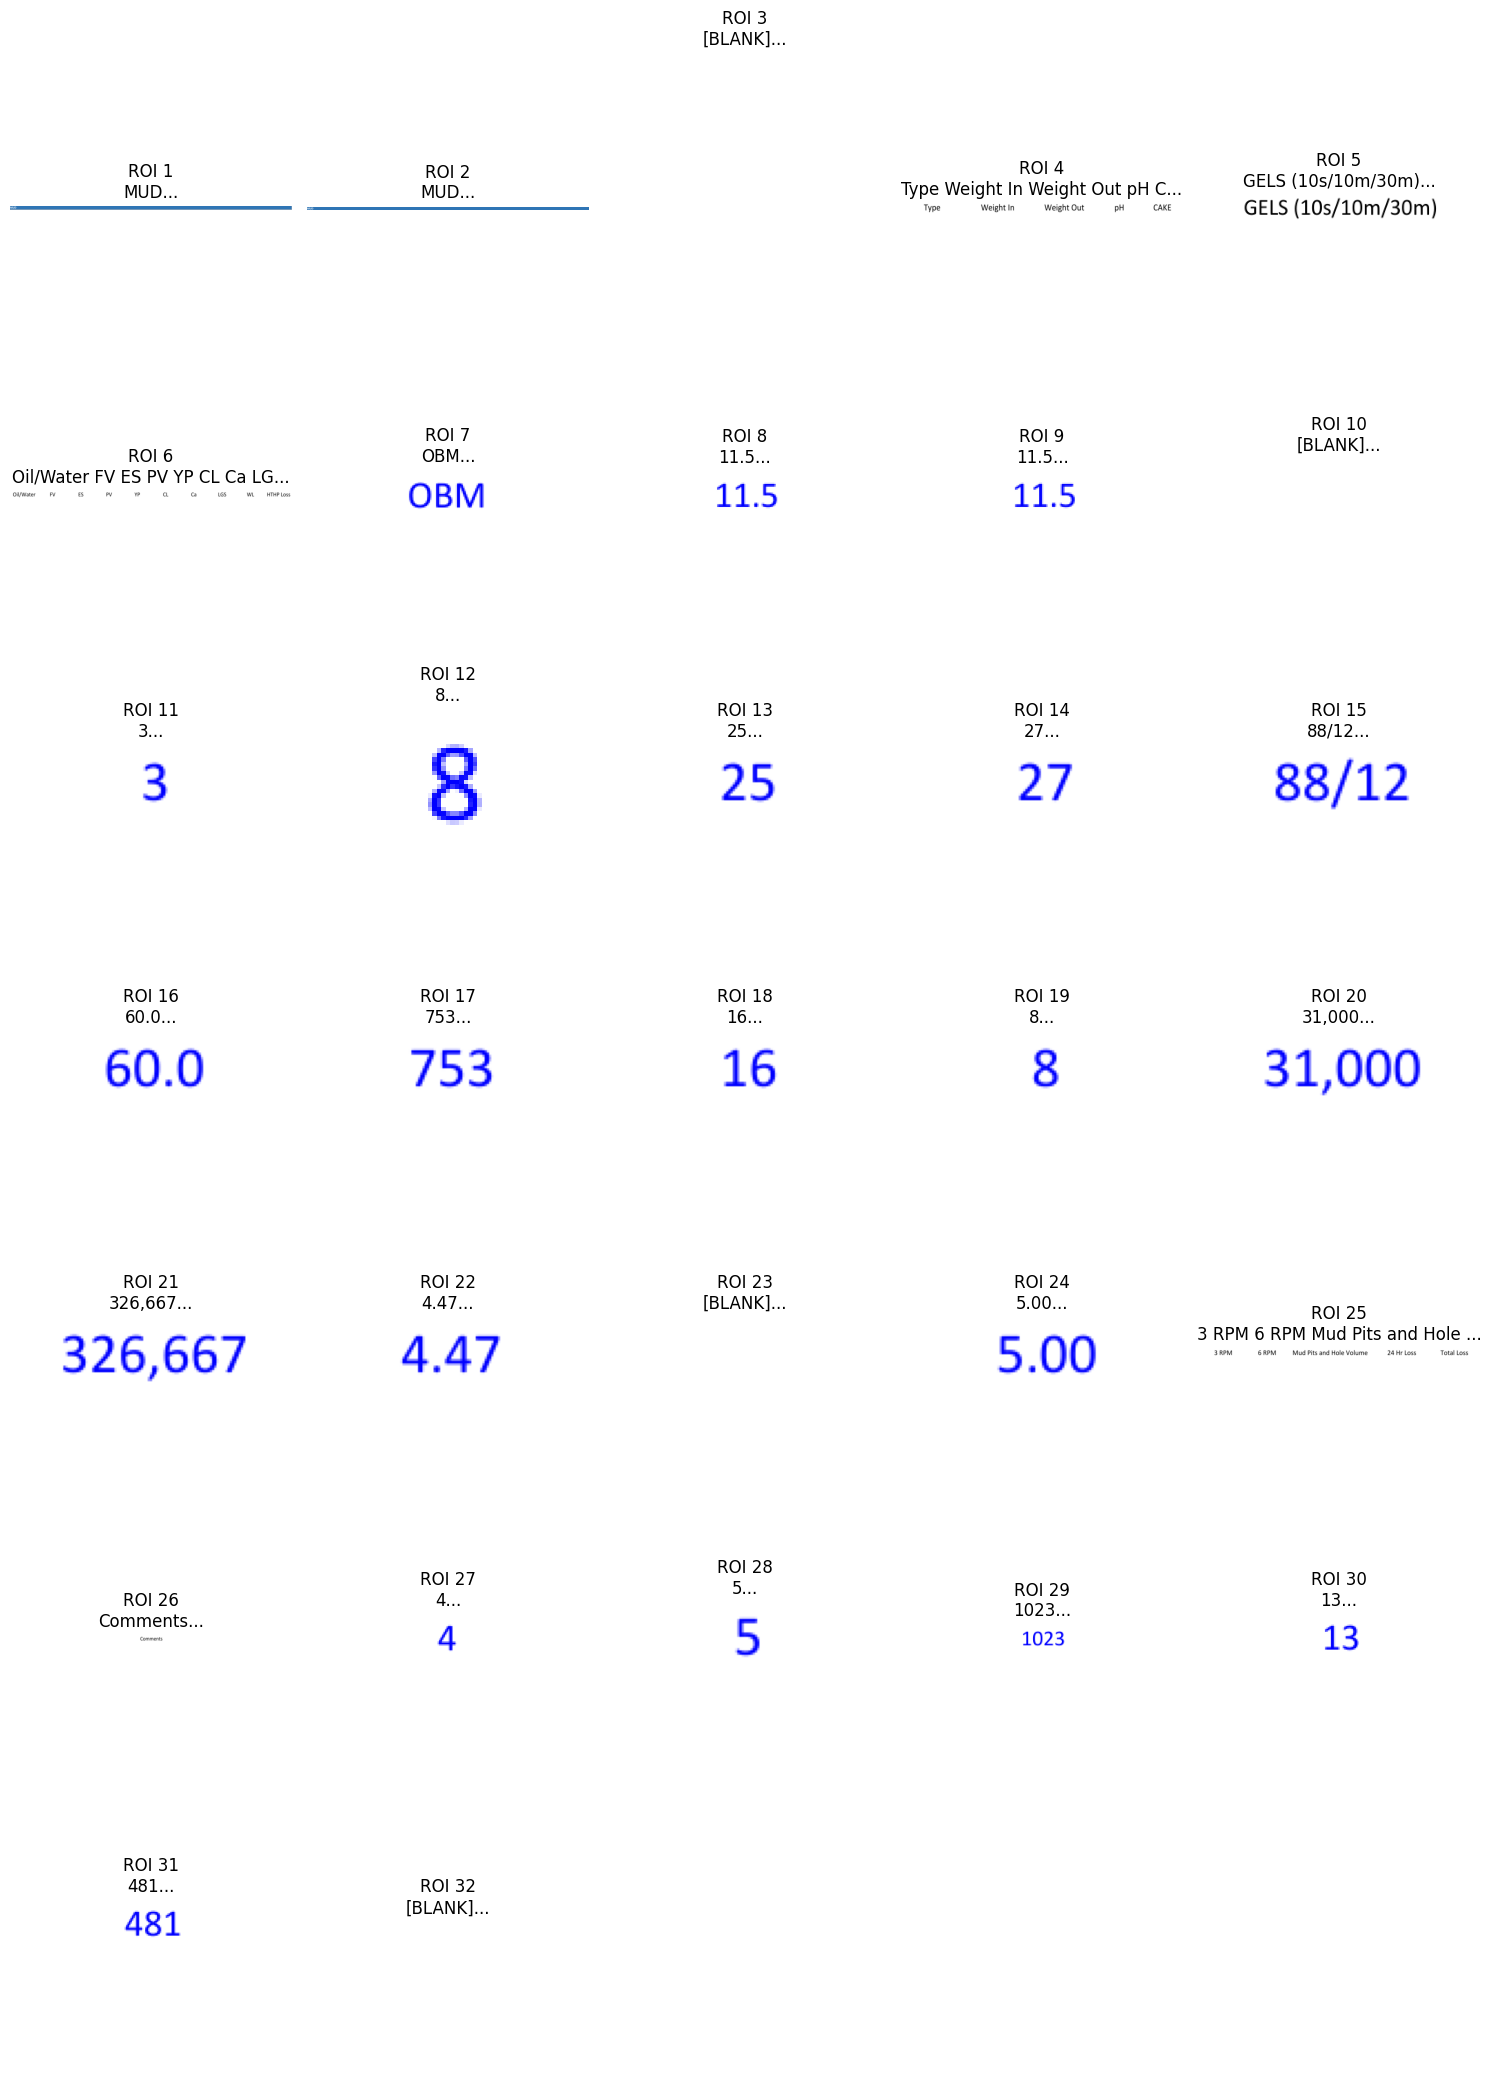

INFO: Row 0 text: MUD MUD [BLANK]
INFO:MudSectionExtractor:Row 0 text: MUD MUD [BLANK]
INFO: Row 1 text: Type Weight In Weight Out pH CAKE GELS (10s/10m/30m) Oil/Water FV ES PV YP CL Ca LGS WL HTHP Loss
INFO:MudSectionExtractor:Row 1 text: Type Weight In Weight Out pH CAKE GELS (10s/10m/30m) Oil/Water FV ES PV YP CL Ca LGS WL HTHP Loss
INFO: Row 2 text: OBM 11.5 11.5 [BLANK] 3 8 25 27 88/12 60.0 753 16 8 31,000 326,667 4.47 [BLANK] 5.00
INFO:MudSectionExtractor:Row 2 text: OBM 11.5 11.5 [BLANK] 3 8 25 27 88/12 60.0 753 16 8 31,000 326,667 4.47 [BLANK] 5.00
INFO: Row 3 text: 3 RPM 6 RPM Mud Pits and Hole Volume 24 Hr Loss Total Loss Comments
INFO:MudSectionExtractor:Row 3 text: 3 RPM 6 RPM Mud Pits and Hole Volume 24 Hr Loss Total Loss Comments
INFO: Row 4 text: 4 5 1023 13 481 [BLANK]
INFO:MudSectionExtractor:Row 4 text: 4 5 1023 13 481 [BLANK]
INFO: Header1: Type Weight In Weight Out pH CAKE GELS (10s/10m/30m) Oil/Water FV ES PV YP CL Ca LGS WL HTHP Loss
INFO:MudSectionExtractor:Heade

----- Extracted DataFrame -----
                         Key                                   Value
0                       Type                                     OBM
1                  Weight In                                    11.5
2                 Weight Out                                    11.5
3                         pH                                 [BLANK]
4                       CAKE                                       3
5         GELS (10s/10m/30m)  {'10s': '8', '10m': '25', '30m': '27'}
6                  Oil/Water                                   88/12
7                         FV                                    60.0
8                         ES                                     753
9                         PV                                      16
10                        YP                                       8
11                        CL                                  31,000
12                        Ca                                 326,667
13

In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt
import math

# ---------------------------------------------------------------------
# Helper Function: Convert DBFS URI to Local Path
# ---------------------------------------------------------------------
def dbfs_to_local_path(dbfs_path):
    """
    Converts a DBFS URI (e.g. "dbfs:/mnt/xxx") to its local path ("/dbfs/mnt/xxx")
    """
    if dbfs_path.startswith("dbfs:/"):
        return "/dbfs/" + dbfs_path[len("dbfs:/"):]
    return dbfs_path

# ---------------------------------------------------------------------
# Helper Function: Check if a file exists on DBFS
# ---------------------------------------------------------------------
def file_exists(dbfs_path):
    """
    Checks if a file exists on DBFS using dbutils.fs.ls.
    If the path does not exist, an exception is thrown.
    """
    try:
        dbutils.fs.ls(dbfs_path)
        return True
    except Exception:
        return False

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("MudSectionExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# show_image utility
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10, 10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# read_cropped_section_image
# ---------------------------------------------------------------------
def read_cropped_section_image(section_path):
    # Check file existence using DBFS API
    if not file_exists(section_path):
        raise FileNotFoundError(f"File not found: {section_path}")
    # Convert DBFS URI to local path for OpenCV
    local_path = dbfs_to_local_path(section_path)
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to load image: {local_path}")
    return img

# ---------------------------------------------------------------------
# preprocess_image
# ---------------------------------------------------------------------
def preprocess_image(img, debug=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("1) Grayscale", gray, cmap='gray', size=(10,10))
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    if debug:
        show_image("2) Adaptive Threshold", thresh, cmap='gray', size=(10,10))
    return thresh

# ---------------------------------------------------------------------
# detect_text_regions
# ---------------------------------------------------------------------
def detect_text_regions(thresh_img, debug=True):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        show_image("3) Detected Text Regions", debug_img, size=(12,12))
    return rois

# ---------------------------------------------------------------------
# perform_ocr_on_rois
# ---------------------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=True):
    results = []
    n = len(rois)
    if debug and n > 0:
        cols = 5
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten() if rows > 1 else [axes]
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config='--psm 6').strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug and i < len(axes):
            roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            axes[i].imshow(roi_rgb)
            axes[i].set_title(f"ROI {i+1}\n{text[:30]}...")
            axes[i].axis("off")
    if debug and n > 0:
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        plt.show()
    return results

# ---------------------------------------------------------------------
# parse_value_row_tokens
# ---------------------------------------------------------------------
def parse_value_row_tokens(expected_headers, tokens):
    """
    Map a flat list of tokens to the expected headers.
    For "GELS (10s/10m/30m)", consume 3 tokens and create a sub-dictionary.
    Expected token count = (number of headers - 1) + 3.
    """
    expected_token_count = (len(expected_headers) - 1) + 3
    logger.info(f"Expected token count: {expected_token_count}, tokens extracted: {tokens}")
    
    # Pad or trim tokens as needed.
    if len(tokens) < expected_token_count:
        tokens += ["[BLANK]"] * (expected_token_count - len(tokens))
        logger.warning("Not enough tokens. Padding with [BLANK].")
    elif len(tokens) > expected_token_count:
        tokens = tokens[:expected_token_count]
        logger.warning("Too many tokens. Trimming the extra tokens.")
    
    result = {}
    idx = 0
    for header in expected_headers:
        if header == "GELS (10s/10m/30m)":
            gels_tokens = tokens[idx:idx+3]
            result[header] = {
                "10s": gels_tokens[0],
                "10m": gels_tokens[1],
                "30m": gels_tokens[2]
            }
            idx += 3
        else:
            result[header] = tokens[idx]
            idx += 1
    logger.info(f"Mapped dictionary: {result}")
    return result

# ---------------------------------------------------------------------
# build_mud_dict_from_rois
# ---------------------------------------------------------------------
def build_mud_dict_from_rois(roi_texts, expected_headers):
    """
    Group OCR results into rows based on the y coordinate.
    Identify header rows and corresponding data rows.
    
    In our case, we expect:
      - A header row (with labels) followed by a data row,
      - Then a second header row (for the remaining fields) followed by a second data row.
    
    We then combine the two data rows' tokens and map them to expected_headers.
    """
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None

    # Group by row based on y coordinate.
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)

    # Sort each row by x coordinate and log its text.
    row_strings = []
    for i, row_cells in enumerate(rows):
        row_cells.sort(key=lambda c: c[0])
        line_text = " ".join(cell[4] for cell in row_cells)
        row_strings.append(line_text)
        logger.info(f"Row {i} text: {line_text}")

    # Based on OCR output expectations:
    # Row 1: header row 1 (first set of labels)
    # Row 2: data row 1 (first set of values)
    # Row 3: header row 2 (remaining labels)
    # Row 4: data row 2 (remaining values)
    header1_line = None
    value1_line = None
    header2_line = None
    value2_line = None

    for i, r_text in enumerate(row_strings):
        if "Type" in r_text and not header1_line:
            header1_line = r_text
            if i + 1 < len(row_strings):
                value1_line = row_strings[i+1]
        elif header1_line and not header2_line and any(kw in r_text for kw in ["RPM", "Mud", "Loss", "Comments"]):
            header2_line = r_text
            if i + 1 < len(row_strings):
                value2_line = row_strings[i+1]
            break

    logger.info(f"Header1: {header1_line}")
    logger.info(f"Value1: {value1_line}")
    logger.info(f"Header2: {header2_line}")
    logger.info(f"Value2: {value2_line}")

    if value1_line is None:
        logger.error("No data row found for header1!")
        return {}

    # Split the data rows into tokens.
    tokens1 = value1_line.split()
    tokens2 = value2_line.split() if value2_line else []
    logger.info(f"Tokens from data row 1: {tokens1}")
    logger.info(f"Tokens from data row 2: {tokens2}")

    # Combine tokens from both data rows.
    combined_tokens = tokens1 + tokens2
    logger.info(f"Combined tokens: {combined_tokens}")

    # Map the tokens to the expected headers.
    return parse_value_row_tokens(expected_headers, combined_tokens)

# ---------------------------------------------------------------------
# main_pipeline
# ---------------------------------------------------------------------
def main_pipeline():
    expected_headers = [
        "Type", "Weight In", "Weight Out", "pH", "CAKE",
        "GELS (10s/10m/30m)", "Oil/Water", "FV", "ES", "PV",
        "YP", "CL", "Ca", "LGS", "WL", "HTHP Loss", "3 RPM",
        "6 RPM", "Mud Pits and Hole Volume", "24 Hr Loss",
        "Total Loss", "Comments"
    ]
    # Use a DBFS URI for the input image
    section_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_3.png"
    try:
        img = read_cropped_section_image(section_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    show_image("Original Cropped Section", img, size=(12,12))
    thresh_img = preprocess_image(img, debug=True)
    rois = detect_text_regions(thresh_img, debug=True)
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    
    # Build the mud dictionary using the combined data rows.
    mud_dict = build_mud_dict_from_rois(roi_texts, expected_headers)
    final_dict = {"MUD": mud_dict}
    logger.info("===== FINAL EXTRACTED MUD DICTIONARY =====")
    logger.info(json.dumps(final_dict, indent=4))
    
    df_final = pd.DataFrame(list(mud_dict.items()), columns=["Key", "Value"])
    print("----- Extracted DataFrame -----")
    print(df_final)
    
    # Define the output folder using a DBFS URI and create it with dbutils.fs.mkdirs
    output_folder_dbfs = "dbfs:/mnt/mini-proj-dd/final_ocr_results"
    dbutils.fs.mkdirs(output_folder_dbfs)
    # Instead of writing using OS-level functions, convert the DataFrame to CSV text
    # and write it directly to DBFS.
    out_file = output_folder_dbfs + "/page_1_section_3_ocr.csv"
    csv_data = df_final.to_csv(index=False)
    dbutils.fs.put(out_file, csv_data, overwrite=True)
    logger.info(f"Final DataFrame saved to {out_file}")

if __name__ == "__main__":
    main_pipeline()


In [0]:
# import os
# import re
# import cv2
# import pytesseract
# import numpy as np
# import pandas as pd
# import logging
# import json
# import matplotlib.pyplot as plt
# import math

# # ---------------------------------------------------------------------
# # Logger Setup
# # ---------------------------------------------------------------------
# logger = logging.getLogger("MudSectionExtractor")
# logger.setLevel(logging.INFO)
# if not logger.handlers:
#     handler = logging.StreamHandler()
#     handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
#     logger.addHandler(handler)

# # ---------------------------------------------------------------------
# # show_image utility
# # ---------------------------------------------------------------------
# def show_image(title, img, cmap=None, size=(10, 10)):
#     plt.figure(figsize=size)
#     if cmap:
#         plt.imshow(img, cmap=cmap)
#     else:
#         if len(img.shape) == 3:
#             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         else:
#             plt.imshow(img, cmap='gray')
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

# # ---------------------------------------------------------------------
# # read_cropped_section_image
# # ---------------------------------------------------------------------
# def read_cropped_section_image(section_path):
#     local_path = section_path.replace("dbfs:", "/dbfs") if section_path.startswith("dbfs:") else section_path
#     if not os.path.exists(local_path):
#         raise FileNotFoundError(f"File not found: {local_path}")
#     img = cv2.imread(local_path)
#     if img is None:
#         raise FileNotFoundError(f"OpenCV failed to load image: {local_path}")
#     return img

# # ---------------------------------------------------------------------
# # preprocess_image
# # ---------------------------------------------------------------------
# def preprocess_image(img, debug=True):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     if debug:
#         show_image("1) Grayscale", gray, cmap='gray', size=(10,10))
#     thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                    cv2.THRESH_BINARY, 15, 9)
#     if debug:
#         show_image("2) Adaptive Threshold", thresh, cmap='gray', size=(10,10))
#     return thresh

# # ---------------------------------------------------------------------
# # detect_text_regions
# # ---------------------------------------------------------------------
# def detect_text_regions(thresh_img, debug=True):
#     contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     rois = []
#     debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
#     for cnt in contours:
#         x, y, w, h = cv2.boundingRect(cnt)
#         if w > 30 and h > 15:
#             rois.append((x, y, w, h))
#             cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
#     rois.sort(key=lambda b: (b[1], b[0]))
#     if debug:
#         show_image("3) Detected Text Regions", debug_img, size=(12,12))
#     return rois

# # ---------------------------------------------------------------------
# # perform_ocr_on_rois
# # ---------------------------------------------------------------------
# def perform_ocr_on_rois(img, rois, debug=True):
#     results = []
#     n = len(rois)
#     if debug and n > 0:
#         cols = 5
#         rows = math.ceil(n / cols)
#         fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
#         axes = axes.flatten() if rows > 1 else [axes]
#     for i, (x, y, w, h) in enumerate(rois):
#         roi = img[y:y+h, x:x+w]
#         text = pytesseract.image_to_string(roi, config='--psm 6').strip()
#         if not text:
#             text = "[BLANK]"
#         results.append((x, y, w, h, text))
#         if debug and i < len(axes):
#             roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
#             axes[i].imshow(roi_rgb)
#             axes[i].set_title(f"ROI {i+1}\n{text[:30]}...")
#             axes[i].axis("off")
#     if debug and n > 0:
#         for j in range(i + 1, len(axes)):
#             axes[j].axis("off")
#         plt.tight_layout()
#         plt.show()
#     return results

# # ---------------------------------------------------------------------
# # parse_value_row_tokens
# # ---------------------------------------------------------------------
# def parse_value_row_tokens(expected_headers, tokens):
#     """
#     Map a flat list of tokens to the expected headers.
#     For "GELS (10s/10m/30m)", consume 3 tokens and create a sub-dictionary.
#     Expected token count = (number of headers - 1) + 3.
#     """
#     expected_token_count = (len(expected_headers) - 1) + 3
#     logger.info(f"Expected token count: {expected_token_count}, tokens extracted: {tokens}")
    
#     # Pad or trim tokens as needed.
#     if len(tokens) < expected_token_count:
#         tokens += ["[BLANK]"] * (expected_token_count - len(tokens))
#         logger.warning("Not enough tokens. Padding with [BLANK].")
#     elif len(tokens) > expected_token_count:
#         tokens = tokens[:expected_token_count]
#         logger.warning("Too many tokens. Trimming the extra tokens.")
    
#     result = {}
#     idx = 0
#     for header in expected_headers:
#         if header == "GELS (10s/10m/30m)":
#             gels_tokens = tokens[idx:idx+3]
#             result[header] = {
#                 "10s": gels_tokens[0],
#                 "10m": gels_tokens[1],
#                 "30m": gels_tokens[2]
#             }
#             idx += 3
#         else:
#             result[header] = tokens[idx]
#             idx += 1
#     logger.info(f"Mapped dictionary: {result}")
#     return result

# # ---------------------------------------------------------------------
# # build_mud_dict_from_rois
# # ---------------------------------------------------------------------
# def build_mud_dict_from_rois(roi_texts, expected_headers):
#     """
#     Group OCR results into rows based on the y coordinate.
#     Identify header rows and corresponding data rows.
    
#     In our case, we expect:
#       - A header row (with labels) followed by a data row,
#       - Then a second header row (for the remaining fields) followed by a second data row.
    
#     We then combine the two data rows' tokens and map them to expected_headers.
#     """
#     row_tolerance = 10
#     rows = []
#     current_row = []
#     prev_y = None

#     # Group by row based on y coordinate.
#     for (x, y, w, h, text) in roi_texts:
#         if prev_y is None or abs(y - prev_y) <= row_tolerance:
#             current_row.append((x, y, w, h, text))
#         else:
#             rows.append(current_row)
#             current_row = [(x, y, w, h, text)]
#         prev_y = y
#     if current_row:
#         rows.append(current_row)

#     # Sort each row by x coordinate and log its text.
#     row_strings = []
#     for i, row_cells in enumerate(rows):
#         row_cells.sort(key=lambda c: c[0])
#         line_text = " ".join(cell[4] for cell in row_cells)
#         row_strings.append(line_text)
#         logger.info(f"Row {i} text: {line_text}")

#     # Based on your OCR output, we expect:
#     # Row 1: header row 1 (first set of labels)
#     # Row 2: data row 1 (first set of values)
#     # Row 3: header row 2 (remaining labels)
#     # Row 4: data row 2 (remaining values)
#     header1_line = None
#     value1_line = None
#     header2_line = None
#     value2_line = None

#     for i, r_text in enumerate(row_strings):
#         if "Type" in r_text and not header1_line:
#             header1_line = r_text
#             if i + 1 < len(row_strings):
#                 value1_line = row_strings[i+1]
#         elif header1_line and not header2_line and any(kw in r_text for kw in ["RPM", "Mud", "Loss", "Comments"]):
#             header2_line = r_text
#             if i + 1 < len(row_strings):
#                 value2_line = row_strings[i+1]
#             break

#     logger.info(f"Header1: {header1_line}")
#     logger.info(f"Value1: {value1_line}")
#     logger.info(f"Header2: {header2_line}")
#     logger.info(f"Value2: {value2_line}")

#     if value1_line is None:
#         logger.error("No data row found for header1!")
#         return {}

#     # Split the data rows into tokens.
#     tokens1 = value1_line.split()
#     tokens2 = value2_line.split() if value2_line else []
#     logger.info(f"Tokens from data row 1: {tokens1}")
#     logger.info(f"Tokens from data row 2: {tokens2}")

#     # Combine tokens from both data rows.
#     combined_tokens = tokens1 + tokens2
#     logger.info(f"Combined tokens: {combined_tokens}")

#     # Map the tokens to the expected headers.
#     return parse_value_row_tokens(expected_headers, combined_tokens)

# # ---------------------------------------------------------------------
# # main_pipeline
# # ---------------------------------------------------------------------
# def main_pipeline():
#     expected_headers = [
#         "Type", "Weight In", "Weight Out", "pH", "CAKE",
#         "GELS (10s/10m/30m)", "Oil/Water", "FV", "ES", "PV",
#         "YP", "CL", "Ca", "LGS", "WL", "HTHP Loss", "3 RPM",
#         "6 RPM", "Mud Pits and Hole Volume", "24 Hr Loss",
#         "Total Loss", "Comments"
#     ]
#     section_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_3.png"
#     try:
#         img = read_cropped_section_image(section_path)
#         logger.info("Image loaded successfully.")
#     except Exception as e:
#         logger.error(e)
#         return

#     show_image("Original Cropped Section", img, size=(12,12))
#     thresh_img = preprocess_image(img, debug=True)
#     rois = detect_text_regions(thresh_img, debug=True)
#     roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    
#     # Build the mud dictionary using the combined data rows.
#     mud_dict = build_mud_dict_from_rois(roi_texts, expected_headers)
#     final_dict = {"MUD": mud_dict}
#     logger.info("===== FINAL EXTRACTED MUD DICTIONARY =====")
#     logger.info(json.dumps(final_dict, indent=4))
    
#     df_final = pd.DataFrame(list(mud_dict.items()), columns=["Key", "Value"])
#     print("----- Extracted DataFrame -----")
#     print(df_final)
    
#     output_folder = "dbfs:/mnt/mini-proj-dd/final_ocr_results"
#     local_folder = output_folder.replace("dbfs:", "/dbfs")
#     os.makedirs(local_folder, exist_ok=True)
#     out_file = os.path.join(local_folder, "page_1_section_3_ocr.csv")
#     df_final.to_csv(out_file, index=False)
#     logger.info(f"Final DataFrame saved to {out_file}")

# if __name__ == "__main__":
#     main_pipeline()
